## A method for computing Model Agnostic Effect Coefficients (MAgEC)

In [1]:
import warnings
warnings.filterwarnings('ignore') 

In [2]:
import numpy as np
import pandas as pd
import transforms as tr
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import magec_utils as mg
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### PIMA Dataset
The Pima are a group of Native Americans living in Arizona. A genetic predisposition allowed this group to survive normally to a diet poor of carbohydrates for years. In the recent years, the PIMA have undergone of a sudden shift from traditional agricultural crops to processed foods, together with a decline in physical activity. The Pima have been under near-constant study since 1965 due to the high incidence rate of Diabetes in PIMA females. The dataset was originally published by the National Institute of Diabetes and Digestive and Kidney Diseases, consisting of 8 diagnostic measurements pertaining to 768 females of age greater than 20.(Smith et al, 1988) and a binary target variable marking whether that woman developed type 2 diabetes within the next 5 years. Three types of models: logistic regression, a random forest, and a deep neural network were trained on the data with two goals. First, to provide a simple dataset with which to access the fidelity of the MAGECS. Second, to directly compare any differences that these three statistical models might learn when trained on the same data!

In [3]:
pima = pd.read_csv('diabetes.csv')
seed = 7
np.random.seed(seed)
x = pima.iloc[:, 0:8]
Y = pima.iloc[:,8]

x_train, x_validation, Y_train, Y_validation = train_test_split(x, Y, test_size=0.2, random_state=seed)

stsc = StandardScaler()
xst_train = stsc.fit_transform(x_train)
xst_train = pd.DataFrame(xst_train, index=x_train.index, columns=x_train.columns)
xst_validation = stsc.transform(x_validation)
xst_validation = pd.DataFrame(xst_validation, index=x_validation.index, columns=x_validation.columns)

# Format
x_validation_p = xst_validation.copy()
x_validation_p['timepoint'] = 0
x_validation_p['case'] = np.arange(len(x_validation_p))
x_validation_p.set_index(['case','timepoint'], inplace=True)
x_validation_p = x_validation_p.sort_index(axis=1)

y_validation_p = pd.DataFrame(Y_validation.copy())
y_validation_p['timepoint'] = 0
y_validation_p['case'] = np.arange(len(x_validation_p))
y_validation_p.set_index(['case','timepoint'], inplace=True)
y_validation_p = y_validation_p.sort_index(axis=1)


# Format
x_train_p = xst_train.copy()
x_train_p['timepoint'] = 0
x_train_p['case'] = np.arange(len(x_train_p))
x_train_p.set_index(['case','timepoint'], inplace=True)
x_train_p = x_train_p.sort_index(axis=1)

In [4]:
# Xst = pd.concat([xst_train, xst_validation])
# Yst = pd.concat([Y_train, Y_validation])

In [5]:
x_validation.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
353,1,90,62,12,43,27.2,0.580,24
236,7,181,84,21,192,35.9,0.586,51
323,13,152,90,33,29,26.8,0.731,43
98,6,93,50,30,64,28.7,0.356,23
701,6,125,78,31,0,27.6,0.565,49


In [6]:
x_validation_p.head()

,,Age,BMI,BloodPressure,DiabetesPedigreeFunction,Glucose,Insulin,Pregnancies,SkinThickness
case,timepoint,,,,,,,,
0,0,-0.773377,-0.645827,-0.359644,0.353425,-0.927785,-0.306836,-0.848867,-0.525387
1,0,1.578677,0.472920,0.797314,0.371810,1.890014,1.062290,0.956690,0.033690
2,0,0.881772,-0.697264,1.112848,0.816093,0.992034,-0.435478,2.762247,0.779127
3,0,-0.860490,-0.452940,-0.990712,-0.332915,-0.834890,-0.113872,0.655764,0.592768
4,0,1.404451,-0.594391,0.481780,0.307465,0.155984,-0.701953,0.655764,0.654887


### MAgECs ("case" level)
Given a model and a dataset with 'scaled' (Z-normalized) features, iterate over dataset rows and features (and timepoints if dataset is a longitudinal dataset) and compute MAgEC coefficients. For a binary classification task the MAgEC coefficient for a given prediction is equal to the difference between the predicted logit probability for that datapoint and the predicted logit probability of a Z-perturbed datapoint. The latter is defined as the original datapoint with a modified feature set to 0 (mean value of scaled feature).

### Multi-Layer-Perceptron Model 

In [7]:
model = load_model('pima_model_sts.h5')

In [8]:
mlp_score = roc_auc_score(y_validation_p, model.predict(x_validation_p))
mlp_score

0.6952432627961656

In [9]:
# from functools import partial
# from keras.wrappers.scikit_learn import KerasClassifier
# def pima_keras(model):
#     return model
# pima_keras = KerasClassifier(partial(pima_keras, model), verbose=0, batch_size=16)

In [10]:
# mg.model_performance(pima_keras, Xst, Yst, 'MLP')

In [11]:
case_mlp = mg.case_magecs(model, x_validation_p, model_name='mlp')

In [12]:
features = ['BloodPressure', 'BMI', 'Glucose', 'Insulin', 'SkinThickness']

In [13]:
# use all feature to normalize MAgECS
magecs_mlp = mg.normalize_magecs(case_mlp, features=None, model_name='mlp')

In [14]:
magecs_mlp.head(3)

features,case,timepoint,mlp_Age,mlp_BMI,mlp_BloodPressure,mlp_DiabetesPedigreeFunction,mlp_Glucose,mlp_Insulin,mlp_Pregnancies,mlp_SkinThickness,orig_prob_mlp,perturb_Age_prob_mlp,perturb_BMI_prob_mlp,perturb_BloodPressure_prob_mlp,perturb_DiabetesPedigreeFunction_prob_mlp,perturb_Glucose_prob_mlp,perturb_Insulin_prob_mlp,perturb_Pregnancies_prob_mlp,perturb_SkinThickness_prob_mlp
0,0,0,0.249736,0.718566,-0.037057,0.006919,-0.025843,0.233703,0.520776,0.305584,0.063786,0.08152,0.127258,0.061483,0.064225,0.062171,0.080258,0.105754,0.086059
1,1,0,-0.782240,-0.420514,0.112158,-0.095649,0.194162,-0.251709,-0.297298,-0.009868,0.744293,0.52175,0.632011,0.770142,0.720795,0.787846,0.679751,0.667174,0.741930
2,2,0,-0.280346,0.386273,0.157763,-0.229775,0.030192,0.060988,-0.814133,-0.164530,0.591666,0.46486,0.745703,0.658987,0.487878,0.604908,0.618258,0.246943,0.517638


In [15]:
np.linalg.norm([0.249736,0.718566,-0.037057,0.006919,-0.025843,0.233703,0.520776,0.305584])

1.0000002179759764

In [16]:
magecs_mlp = magecs_mlp.merge(y_validation_p, left_on=['case', 'timepoint'], right_index=True)

In [17]:
# mg.plot_all_violin(magecs_mlp, features=features, model_name='mlp')

### Random Forest (calibrated)

In [18]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train_p, Y_train)
sigmoidRF = CalibratedClassifierCV(RandomForestClassifier(n_estimators=1000), cv=5, method='sigmoid')
sigmoidRF.fit(x_train_p, Y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
            cv=5, method='sigmoid')

In [19]:
case_rf = mg.case_magecs(sigmoidRF, x_validation_p, model_name='rf')
magecs_rf = mg.normalize_magecs(case_rf, features=None, model_name='rf')
magecs_rf = magecs_rf.merge(y_validation_p, left_on=['case', 'timepoint'], right_index=True)
# mg.plot_all_violin(magecs_rf, features=features, model_name='rf')

In [20]:
rf_score = roc_auc_score(y_validation_p, sigmoidRF.predict(x_validation_p))
rf_score

0.7518538614577681

In [21]:
# mg.model_performance(sigmoidRF, Xst, Yst, 'RF')

### Logistic Regression

In [22]:
lr = LogisticRegression(C=1.)
lr.fit(x_train_p, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [23]:
lr_score = roc_auc_score(y_validation_p, lr.predict(x_validation_p))
lr_score

0.739464640983903

In [24]:
case_lr = mg.case_magecs(lr, x_validation_p, model_name='lr')
magecs_lr = mg.normalize_magecs(case_lr, features=None, model_name='lr')
magecs_lr = magecs_lr.merge(y_validation_p, left_on=['case', 'timepoint'], right_index=True)
# mg.plot_all_violin(magecs_lr, features=features, model_name='lr')

## MAgEC Consensus

In [25]:
joined = mg.magec_models(magecs_mlp, magecs_rf, magecs_lr, Xdata=x_validation_p, Ydata=y_validation_p)

In [26]:
joined.head(3)

,case,timepoint,mlp_Age,mlp_BMI,mlp_BloodPressure,mlp_DiabetesPedigreeFunction,mlp_Glucose,mlp_Insulin,mlp_SkinThickness,perturb_Age_prob_mlp,...,lr_Insulin,lr_SkinThickness,perturb_Age_prob_lr,perturb_BMI_prob_lr,perturb_BloodPressure_prob_lr,perturb_DiabetesPedigreeFunction_prob_lr,perturb_Glucose_prob_lr,perturb_Insulin_prob_lr,perturb_SkinThickness_prob_lr,orig_prob_lr
0,0,0,0.249736,0.718566,-0.037057,0.006919,-0.025843,0.233703,0.305584,0.08152,...,-0.036688,0.015571,0.079574,0.112591,0.066757,0.063725,0.171329,0.069739,0.073770,0.072547
1,1,0,-0.782240,-0.420514,0.112158,-0.095649,0.194162,-0.251709,-0.009868,0.52175,...,0.070729,-0.000556,0.837343,0.815877,0.885038,0.845075,0.465754,0.879739,0.863147,0.863284
2,2,0,-0.280346,0.386273,0.157763,-0.229775,0.030192,0.060988,-0.164530,0.46486,...,-0.035675,-0.015821,0.710667,0.822721,0.784033,0.666296,0.493356,0.721596,0.728289,0.733549


In [27]:
# use AUC scores as weights
weights = {'mlp': mlp_score, 'rf': rf_score, 'lr': lr_score}

### MAgEC individual examples

In [28]:
joined.iloc[2]

case                                         2.000000
timepoint                                    0.000000
mlp_Age                                     -0.280346
mlp_BMI                                      0.386273
mlp_BloodPressure                            0.157763
mlp_DiabetesPedigreeFunction                -0.229775
mlp_Glucose                                  0.030192
mlp_Insulin                                  0.060988
mlp_SkinThickness                           -0.164530
perturb_Age_prob_mlp                         0.464860
perturb_BMI_prob_mlp                         0.745703
perturb_BloodPressure_prob_mlp               0.658987
perturb_DiabetesPedigreeFunction_prob_mlp    0.487878
perturb_Glucose_prob_mlp                     0.604908
perturb_Insulin_prob_mlp                     0.618258
perturb_SkinThickness_prob_mlp               0.517638
orig_prob_mlp                                0.591666
Age                                          0.881772
BMI                         

## MAgEC Policy

### Ranked MAgECs (rank=1)

In [29]:
# ranks1 = mg.magec_rank(joined, rank=1, features=features)
# compute ranked MAgECs
ranks1 = mg.magec_rank(joined[joined['Outcome'] == 1], rank=1, features=features)

In [30]:
ranks1.head(3)

,case,timepoint,Outcome,mlp_magec,mlp_feat,rf_magec,rf_feat,lr_magec,lr_feat,perturb_BloodPressure_prob_mlp,...,perturb_SkinThickness_prob_rf,perturb_SkinThickness_prob_lr,orig_prob_mlp,orig_prob_rf,orig_prob_lr,BloodPressure,BMI,Glucose,Insulin,SkinThickness
0,1,0,1,-0.420514,BMI,-0.958529,Glucose,-0.951876,Glucose,0.770142,...,0.849998,0.863147,0.744293,0.850585,0.863284,0.797314,0.472920,1.890014,1.062290,0.033690
1,2,0,1,-0.164530,SkinThickness,-0.282895,Glucose,-0.614731,Glucose,0.658987,...,0.473091,0.728289,0.591666,0.493407,0.733549,1.112848,-0.697264,0.992034,-0.435478,0.779127
2,4,0,1,-0.054893,SkinThickness,-0.402233,Insulin,-0.268446,Glucose,0.345445,...,0.471435,0.348880,0.355166,0.490020,0.354004,0.481780,-0.594391,0.155984,-0.701953,0.654887


In [31]:
ranks1.iloc[1]

case                                          2
timepoint                                     0
Outcome                                       1
mlp_magec                              -0.16453
mlp_feat                          SkinThickness
rf_magec                              -0.282895
rf_feat                                 Glucose
lr_magec                              -0.614731
lr_feat                                 Glucose
perturb_BloodPressure_prob_mlp         0.658987
perturb_BloodPressure_prob_rf          0.433044
perturb_BloodPressure_prob_lr          0.784033
perturb_BMI_prob_mlp                   0.745703
perturb_BMI_prob_rf                    0.802258
perturb_BMI_prob_lr                    0.822721
perturb_Glucose_prob_mlp               0.604908
perturb_Glucose_prob_rf                0.383129
perturb_Glucose_prob_lr                0.493356
perturb_Insulin_prob_mlp               0.618258
perturb_Insulin_prob_rf                0.484568
perturb_Insulin_prob_lr                0

In [32]:
mg.print_ranks_stats(ranks1)

	 mlp MAgEC Stats
**** mlp_feat ****
BMI              23
Insulin          18
BloodPressure     7
SkinThickness     5
not_found         3
Glucose           1
Name: mlp_feat, dtype: int64
***********
	 rf MAgEC Stats
**** rf_feat ****
Glucose          34
Insulin          18
BloodPressure     2
SkinThickness     2
BMI               1
Name: rf_feat, dtype: int64
***********
	 lr MAgEC Stats
**** lr_feat ****
Glucose          39
BMI              12
Insulin           4
BloodPressure     2
Name: lr_feat, dtype: int64
***********


### Consensus using rank=1 and 'sum' policy

In [33]:
consensus1a = mg.magec_consensus(ranks1, use_weights=True, weights=weights)

In [34]:
consensus1a.head(3)

,case,timepoint,winner,score,consensus,models,avg_percent_consensus,avg_percent_all
0,1,0,Glucose,3.401724,2,"[lr, rf]",38.104730,23.452653
1,2,0,Glucose,2.388945,2,"[lr, rf]",27.547160,17.618734
2,4,0,Insulin,1.154087,1,[rf],20.921001,-2.986308


In [35]:
consensus1a.winner.value_counts()

Glucose          32
Insulin          11
BMI              10
BloodPressure     3
SkinThickness     1
Name: winner, dtype: int64

In [36]:
consensus1a[['winner','score','consensus']].groupby(['winner']).agg(['mean','std', 'count'])

score                 consensus                
                   mean       std count      mean       std count
winner                                                           
BMI            2.952126  0.823023    10  2.100000  0.316228    10
BloodPressure  2.007676  0.598498     3  2.000000  0.000000     3
Glucose        2.935300  0.584766    32  1.937500  0.245935    32
Insulin        1.985523  0.603627    11  1.636364  0.504525    11
SkinThickness  1.041637       NaN     1  1.000000       NaN     1

### Consensus using rank=1 and 'mean' policy

In [37]:
consensus1b = mg.magec_consensus(ranks1, use_weights=True, weights=weights, policy='mean')

In [38]:
consensus1b.head(3)

,case,timepoint,winner,score,consensus,models,avg_percent_consensus,avg_percent_all
0,1,0,Glucose,1.700862,2,"[lr, rf]",38.104730,23.452653
1,2,0,Glucose,1.194472,2,"[lr, rf]",27.547160,17.618734
2,4,0,Insulin,1.154087,1,[rf],20.921001,-2.986308


In [39]:
consensus1b.winner.value_counts()

Glucose          31
Insulin          13
BMI               9
BloodPressure     2
SkinThickness     2
Name: winner, dtype: int64

In [40]:
consensus1b[['winner','score','consensus']].groupby(['winner']).agg(['mean','std', 'count'])

score                 consensus                
                   mean       std count      mean       std count
winner                                                           
BMI            1.420645  0.245249     9  2.111111  0.333333     9
BloodPressure  0.831819  0.039468     2  2.000000  0.000000     2
Glucose        1.519161  0.216372    31  1.870968  0.340777    31
Insulin        1.300601  0.249940    13  1.538462  0.518875    13
SkinThickness  1.151760  0.155737     2  1.000000  0.000000     2

### Ranked MAgECs (rank=3)

In [41]:
# ranks3 = mg.magec_rank(joined, rank=3)
ranks3 = mg.magec_rank(joined[joined['Outcome'] == 1], rank=3, features=features)

In [42]:
ranks3.head()

,case,timepoint,Outcome,mlp_magec_3,mlp_feat_3,mlp_magec_2,mlp_feat_2,mlp_magec_1,mlp_feat_1,rf_magec_3,...,perturb_SkinThickness_prob_rf,perturb_SkinThickness_prob_lr,orig_prob_mlp,orig_prob_rf,orig_prob_lr,BloodPressure,BMI,Glucose,Insulin,SkinThickness
0,1,0,1,-0.009868,SkinThickness,-0.251709,Insulin,-0.420514,BMI,-0.124540,...,0.849998,0.863147,0.744293,0.850585,0.863284,0.797314,0.472920,1.890014,1.062290,0.033690
1,2,0,1,NaN,not_found,NaN,not_found,-0.164530,SkinThickness,-0.051160,...,0.473091,0.728289,0.591666,0.493407,0.733549,1.112848,-0.697264,0.992034,-0.435478,0.779127
2,4,0,1,-0.000798,Glucose,-0.038680,BloodPressure,-0.054893,SkinThickness,-0.010401,...,0.471435,0.348880,0.355166,0.490020,0.354004,0.481780,-0.594391,0.155984,-0.701953,0.654887
3,5,0,1,NaN,not_found,-0.040073,Glucose,-0.094907,BMI,-0.080207,...,0.448265,0.501284,0.219518,0.491189,0.490379,0.166246,0.087145,0.403703,-0.701953,-1.270824
4,7,0,1,NaN,not_found,NaN,not_found,NaN,not_found,-0.018505,...,0.130077,0.284264,0.022879,0.139809,0.275472,-0.780356,-0.851574,0.589492,-0.701953,-1.270824


In [43]:
ranks3.iloc[1]

case                                          2
timepoint                                     0
Outcome                                       1
mlp_magec_3                                 NaN
mlp_feat_3                            not_found
mlp_magec_2                                 NaN
mlp_feat_2                            not_found
mlp_magec_1                            -0.16453
mlp_feat_1                        SkinThickness
rf_magec_3                           -0.0511598
rf_feat_3                         SkinThickness
rf_magec_2                            -0.152834
rf_feat_2                         BloodPressure
rf_magec_1                            -0.282895
rf_feat_1                               Glucose
lr_magec_3                           -0.0158208
lr_feat_3                         SkinThickness
lr_magec_2                           -0.0356751
lr_feat_2                               Insulin
lr_magec_1                            -0.614731
lr_feat_1                               

In [44]:
mg.print_ranks_stats(ranks3)

	 mlp MAgEC Stats
**** mlp_feat_3 ****
not_found        31
SkinThickness    10
Glucose           6
BloodPressure     5
BMI               5
Name: mlp_feat_3, dtype: int64
***********
**** mlp_feat_2 ****
SkinThickness    14
Insulin          12
not_found        11
BloodPressure     8
Glucose           7
BMI               5
Name: mlp_feat_2, dtype: int64
***********
**** mlp_feat_1 ****
BMI              23
Insulin          18
BloodPressure     7
SkinThickness     5
not_found         3
Glucose           1
Name: mlp_feat_1, dtype: int64
***********
	 rf MAgEC Stats
**** rf_feat_3 ****
SkinThickness    17
BloodPressure    14
Insulin          11
not_found         8
BMI               4
Glucose           3
Name: rf_feat_3, dtype: int64
***********
**** rf_feat_2 ****
Insulin          19
SkinThickness    17
BloodPressure     9
BMI               8
Glucose           3
not_found         1
Name: rf_feat_2, dtype: int64
***********
**** rf_feat_1 ****
Glucose          34
Insulin          18
BloodPres

### Consensus using rank=3 and 'sum' policy

In [45]:
consensus3a = mg.magec_consensus(ranks3, use_weights=True, weights=weights)

In [46]:
consensus3a.head()

,case,timepoint,winner,score,consensus,models,avg_percent_consensus,avg_percent_all
0,1,0,Glucose,3.401724,2,"[lr, rf]",38.104730,23.452653
1,2,0,SkinThickness,2.418072,3,"[lr, mlp, rf]",5.782104,5.782104
2,4,0,SkinThickness,2.350055,3,"[lr, mlp, rf]",3.037897,3.037897
3,5,0,Insulin,2.390590,2,"[lr, rf]",16.329457,3.562787
4,7,0,Glucose,2.439343,2,"[lr, rf]",33.796203,21.354521


In [47]:
consensus3a[['winner','score','consensus']].groupby(['winner']).agg(['mean','std', 'count'])

score                 consensus                
                   mean       std count      mean       std count
winner                                                           
BMI            3.613477  0.754045    13  2.846154  0.375534    13
BloodPressure  3.003388  0.712872     3  3.000000  0.000000     3
Glucose        3.177623  0.478891    29  2.206897  0.412251    29
Insulin        2.241434  0.451787     6  2.000000  0.000000     6
SkinThickness  2.476760  0.217565     6  3.000000  0.000000     6

In [48]:
consensus3a.winner.value_counts()

Glucose          29
BMI              13
Insulin           6
SkinThickness     6
BloodPressure     3
Name: winner, dtype: int64

### Consensus using rank=3 and 'mean' policy

In [49]:
consensus3b = mg.magec_consensus(ranks3, use_weights=True, weights=weights, policy='mean')

In [50]:
consensus3b.head()

,case,timepoint,winner,score,consensus,models,avg_percent_consensus,avg_percent_all
0,1,0,Glucose,1.700862,2,"[lr, rf]",38.104730,23.452653
1,2,0,Glucose,1.194472,2,"[lr, rf]",27.547160,17.618734
2,4,0,Insulin,1.026630,2,"[lr, rf]",13.554333,-2.986308
3,5,0,Insulin,1.195295,2,"[lr, rf]",16.329457,3.562787
4,7,0,Glucose,1.219671,2,"[lr, rf]",33.796203,21.354521


In [51]:
consensus3b[['winner','score','consensus']].groupby(['winner']).agg(['mean','std', 'count'])

score                 consensus                
                   mean       std count      mean       std count
winner                                                           
BMI            1.333949  0.229728     9  2.777778  0.440959     9
BloodPressure  0.846058       NaN     1  3.000000       NaN     1
Glucose        1.487887  0.220519    31  2.161290  0.373878    31
Insulin        1.132820  0.184468    15  1.866667  0.351866    15
SkinThickness  0.862185       NaN     1  1.000000       NaN     1

In [52]:
consensus3b.winner.value_counts()

Glucose          31
Insulin          15
BMI               9
BloodPressure     1
SkinThickness     1
Name: winner, dtype: int64

### MAgEC correlations

In [53]:
corr = joined[joined.columns[2:]].corr()

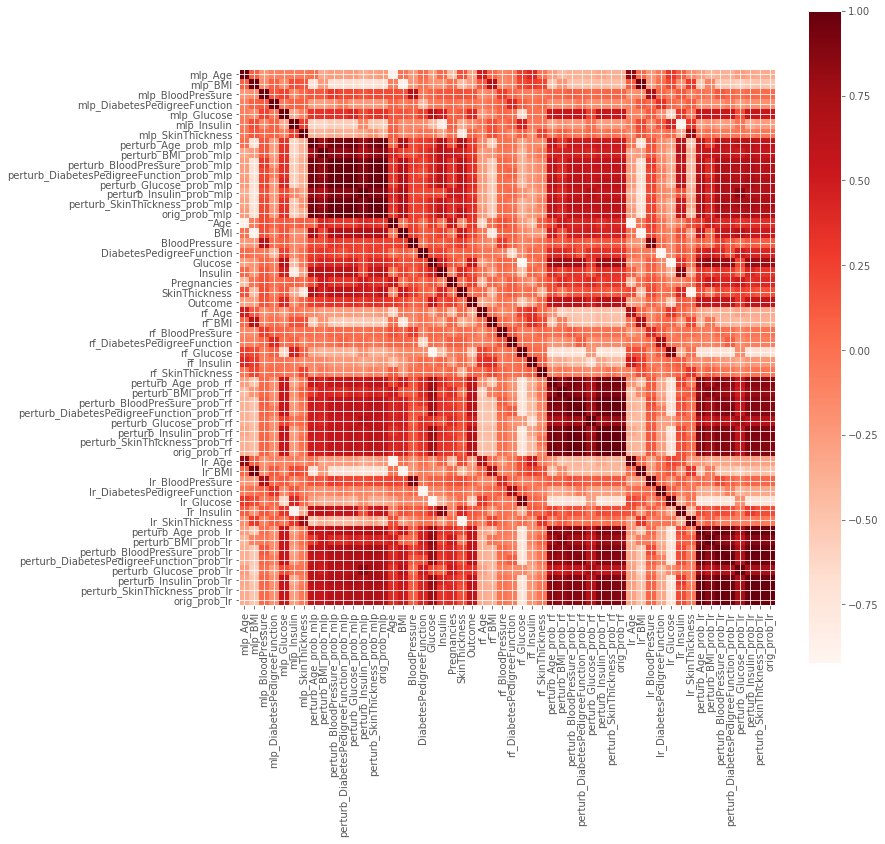

In [54]:
plt.figure(figsize=[12,12])
plt.style.use('ggplot')
plt.imshow(corr, cmap=plt.cm.Reds, interpolation='nearest')
plt.colorbar()
tick_marks = [i for i in range(len(joined.columns[2:]))]
plt.xticks(tick_marks, joined.columns[2:], rotation='vertical')
plt.yticks(tick_marks, joined.columns[2:]);

## MAgECs population similarity

In [55]:
sim_mlp = mg.magec_similarity(magecs_mlp, x_validation_p, model_name='mlp')
sim_rf = mg.magec_similarity(magecs_rf, x_validation_p, model_name='rf')
sim_lr = mg.magec_similarity(magecs_lr, x_validation_p, model_name='lr')

In [56]:
print("Top Absolute Correlationsin in MLP model")
print(mg.get_top_abs_correlations(sim_mlp, 10))

Top Absolute Correlationsin in MLP model
mlp_BMI            BMI              0.862294
mlp_Insulin        Insulin          0.797427
mlp_SkinThickness  SkinThickness    0.730571
mlp_BloodPressure  BloodPressure    0.659626
mlp_Glucose        Glucose          0.653958
Glucose            Outcome          0.544038
BMI                SkinThickness    0.509936
Glucose            Insulin          0.470695
mlp_Glucose        Insulin          0.468632
mlp_BMI            SkinThickness    0.444827
dtype: float64


In [57]:
print("Top Absolute Correlationsin in RF model")
print(mg.get_top_abs_correlations(sim_rf, 5))

Top Absolute Correlationsin in RF model
rf_Glucose                   Glucose                     0.922416
rf_BMI                       BMI                         0.728756
rf_DiabetesPedigreeFunction  DiabetesPedigreeFunction    0.614637
Glucose                      Outcome                     0.544038
rf_Glucose                   Outcome                     0.511843
dtype: float64


In [58]:
print("Top Absolute Correlationsin LR model")
print(mg.get_top_abs_correlations(sim_lr, 5))

Top Absolute Correlationsin LR model
lr_Glucose                   Glucose                     0.921184
lr_BloodPressure             BloodPressure               0.895361
lr_DiabetesPedigreeFunction  DiabetesPedigreeFunction    0.892023
lr_SkinThickness             SkinThickness               0.871342
lr_BMI                       BMI                         0.871290
dtype: float64


### PIMA Exploratory Data Analysis (EDA)

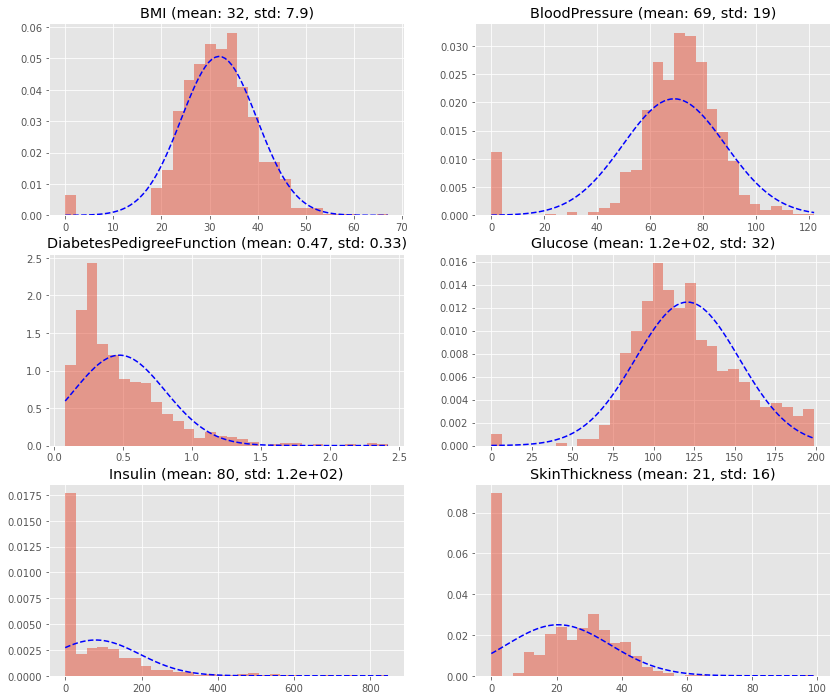

In [59]:
mg.plot_pima_features(pima);

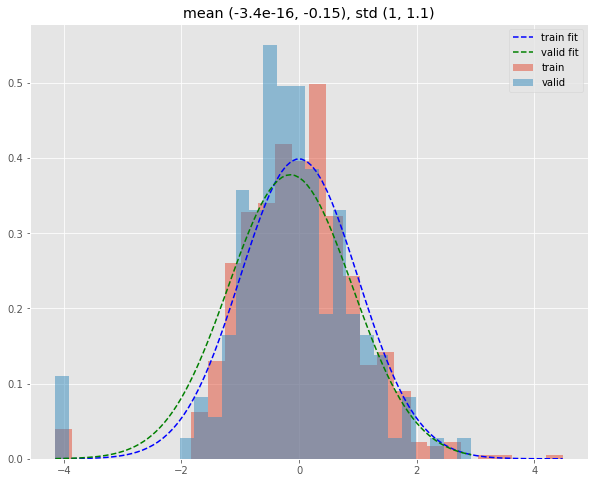

In [60]:
mg.plot_train_valid(x_train_p, x_validation_p, 'BMI')

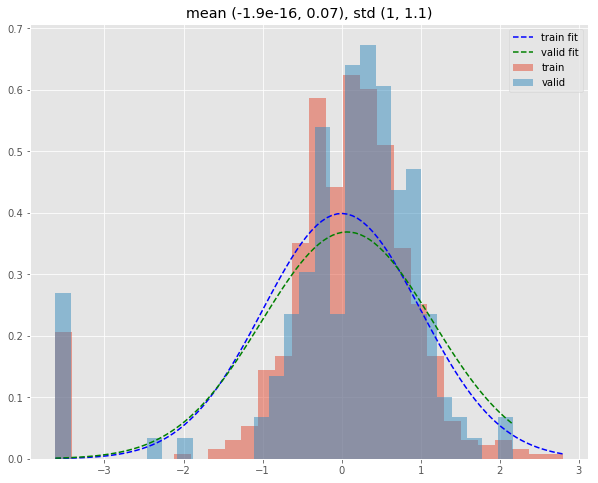

In [61]:
mg.plot_train_valid(x_train_p, x_validation_p, 'BloodPressure')

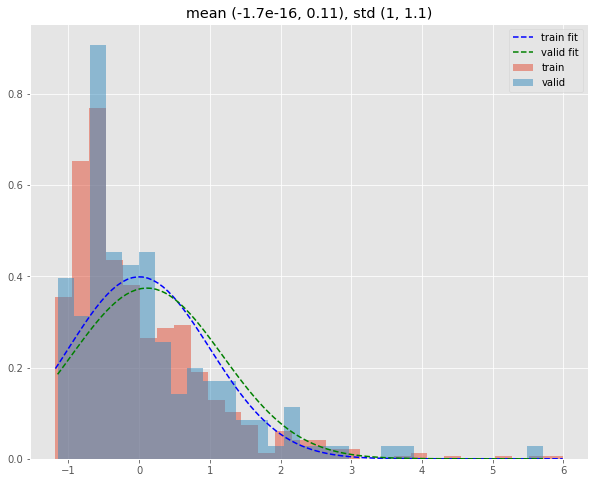

In [62]:
mg.plot_train_valid(x_train_p, x_validation_p, 'DiabetesPedigreeFunction')

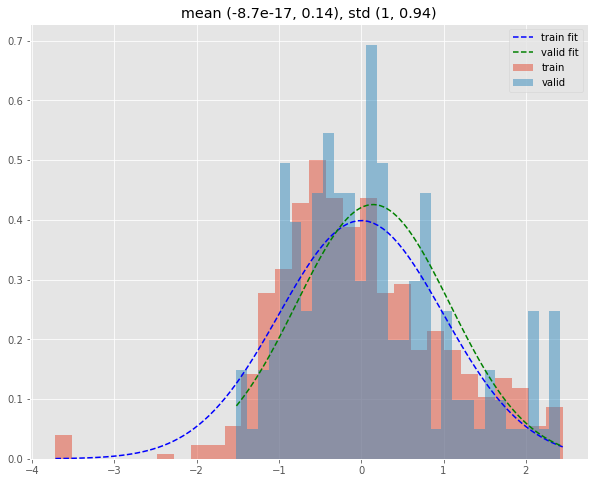

In [63]:
mg.plot_train_valid(x_train_p, x_validation_p, 'Glucose')

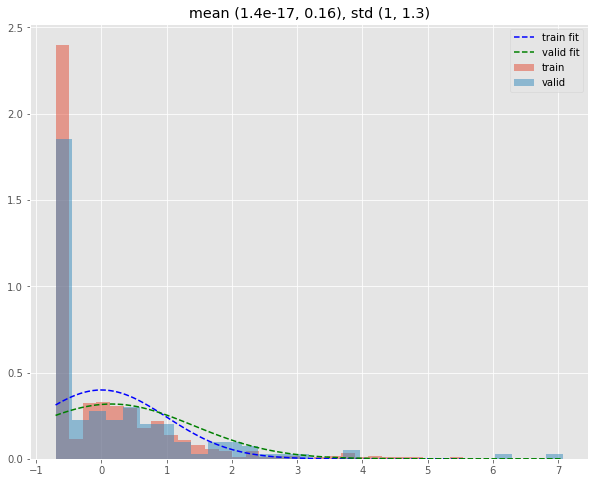

In [64]:
mg.plot_train_valid(x_train_p, x_validation_p, 'Insulin')

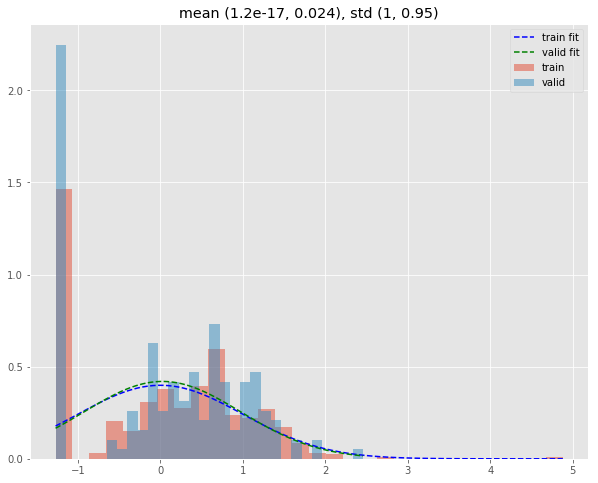

In [65]:
mg.plot_train_valid(x_train_p, x_validation_p, 'SkinThickness')